## Generate detailed report task using orchestrator


### manager should be able to create workers dynamically

In [21]:
from dotenv import load_dotenv
load_dotenv()
import os

#os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq
llm = ChatGroq(model = "llama-3.3-70b-versatile")    #"qwen/qwen3-32b")

result = llm.invoke("Hello")
result

AIMessage(content="Hello. It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 36, 'total_tokens': 61, 'completion_time': 0.052767152, 'completion_tokens_details': None, 'prompt_time': 0.007625917, 'prompt_tokens_details': None, 'queue_time': 0.460903421, 'total_time': 0.060393069}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_bebe2dd4fb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019ba2e9-52e4-7371-aee0-f15be4ca520e-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 36, 'output_tokens': 25, 'total_tokens': 61})

In [22]:
from typing_extensions import Literal,TypedDict
from typing import Annotated,List
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage

Every section will have a name and detailed description

In [23]:
class Section(BaseModel):
    name : str=Field(description="name for this section of the report")
    description: str=Field(description="Brief overview of the main topic and concept of the section")

class Sections(BaseModel):
    sections:List[Section] = Field(description = "Sections of the report")



## agument the llm for schema for structured output

planner = llm.with_structured_output(Sections)


## Creating workers dynamically in langgraph

Because orchestrator worker weorkflow are common, LangGraph has the sendAPI to support this. It lets you dynamically create workers nodes and send each one of specific input

In [24]:
## Creating workers dynamically in langgraph
from langgraph.constants import Send
import operator
class State(TypedDict):
    topic:str
    sections:list[Section]
    completed_sections:Annotated[list,operator.add] ##. all workers write to this key in parallel
    final_report : str

class WorkerState(TypedDict):
    section:Section
    completed_sections:Annotated[list,operator.add]

/var/folders/z1/7f3xn6_126gg27q58_vhrybr0000gn/T/ipykernel_37947/3329159887.py:2: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [25]:
def orchestrator(state:State):
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )
    print("report sections",report_sections)
    return {"sections":report_sections.sections}

def llm_call(state:WorkerState):
    """worker writes a section of the report"""
    # generate sections

    section = llm.invoke(
        [
            SystemMessage(content = " Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."),
            HumanMessage(content=f"Here is the section name : {state['section'].name} and description: {state['section'].description}")

        ]
    )
    return {"completed_sections":[section.content]}


def assigne_workers(state:State):
    """Assign a worker to each section in the plan"""
    # kickoff section writing parallel via send() API
    return [Send("llm_call",{"section":s}) for s in state["sections"]]

def synthesizer(state:State):
    """synthesizer full report from sections"""
    completed_sections = state['completed_sections']
    completed_report_sections = "\n\n--\n\n".join(completed_sections)
    return {"final_report":completed_report_sections}

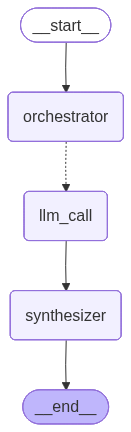

In [26]:
## build workflow

from langgraph.graph import StateGraph
from typing_extensions import TypedDict
from langgraph.graph import START,END, StateGraph
from IPython.display import Image,display
orchestrator_worker_builder = StateGraph(State)
orchestrator_worker_builder.add_node("orchestrator",orchestrator)
orchestrator_worker_builder.add_node("llm_call",llm_call)
orchestrator_worker_builder.add_node("synthesizer",synthesizer)
orchestrator_worker_builder.add_edge(START,"orchestrator")

orchestrator_worker_builder.add_conditional_edges(
    "orchestrator",assigne_workers,["llm_call"])
orchestrator_worker_builder.add_edge("llm_call","synthesizer")
orchestrator_worker_builder.add_edge("synthesizer",END)

orchestrator_worker = orchestrator_worker_builder.compile()
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))




In [27]:
state = orchestrator_worker.invoke({"topic":"create a report in agentic ai RAGs"})
from IPython.display import Markdown
Markdown(state["final_report"])

report sections sections=[Section(name='Introduction', description='Overview of Agentic AI RAGs and their significance'), Section(name='Technical Details', description='In-depth explanation of Agentic AI RAGs architecture and components'), Section(name='Applications and Use Cases', description='Exploration of the potential applications and use cases of Agentic AI RAGs'), Section(name='Conclusion', description='Summary of key findings and future directions for Agentic AI RAGs')]


### Introduction and Description: Overview of Agentic AI RAGs and their Significance
Agentic AI RAGs (Retrieve, Augment, Generate) represent a paradigm shift in artificial intelligence, combining the capabilities of retrieval, augmentation, and generation to create highly sophisticated and autonomous AI systems. These systems are designed to retrieve relevant information from vast datasets, augment this information with external knowledge or user input, and generate new content, decisions, or actions based on this augmented knowledge. The significance of Agentic AI RAGs lies in their potential to revolutionize numerous fields, including but not limited to, healthcare, finance, education, and customer service, by providing more accurate, personalized, and efficient solutions. 

#### Key Features of Agentic AI RAGs
- **Autonomy**: The ability of these systems to operate with a degree of independence, making decisions based on the information they retrieve and augment.
- **Adaptability**: Agentic AI RAGs can adapt to new information, changing contexts, or user needs, ensuring their outputs remain relevant and effective.
- **Continuous Learning**: These systems can learn from the outcomes of their generated actions or content, improving their performance over time.

#### Impact and Applications
The impact of Agentic AI RAGs is multifaceted, with potential applications in:
- **Healthcare**: Personalized medicine, predictive diagnosis, and tailored treatment plans.
- **Education**: Adaptive learning platforms, intelligent tutoring systems, and automated grading.
- **Finance**: Risk analysis, portfolio management, and fraud detection.
- **Customer Service**: Chatbots, virtual assistants, and personalized marketing.

The development and integration of Agentic AI RAGs into various sectors are expected to significantly enhance efficiency, accuracy, and user experience, marking a new era in AI-driven innovation.

--

### Technical Details
#### Agentic AI RAGs Architecture
The Agentic AI RAGs (Retrieval-Augmented Generation) architecture is a complex system comprising multiple components that work together to generate human-like responses. The architecture can be broken down into the following key components:
* **Knowledge Retrieval Module**: This module is responsible for retrieving relevant information from a vast knowledge base. It uses a combination of natural language processing (NLP) and information retrieval techniques to identify the most relevant pieces of information.
* **Context Understanding Module**: This module analyzes the input prompt or query to understand the context and intent behind it. It uses techniques such as named entity recognition, part-of-speech tagging, and dependency parsing to extract meaningful information.
* **Question Answering Module**: This module uses the retrieved information and context understanding to generate answers to the input query. It employs a range of techniques, including machine learning algorithms and knowledge graph-based approaches.
* **Response Generation Module**: This module takes the generated answer and uses it to create a human-like response. It uses techniques such as language generation, dialogue management, and sentiment analysis to create a response that is engaging, informative, and contextually relevant.

#### Components of Agentic AI RAGs
The Agentic AI RAGs architecture consists of several key components, including:
* **Encoder**: The encoder is responsible for converting the input query into a numerical representation that can be processed by the model.
* **Retriever**: The retriever is responsible for retrieving relevant information from the knowledge base.
* **Generator**: The generator is responsible for generating the final response based on the retrieved information and context understanding.
* **Ranker**: The ranker is responsible for ranking the generated responses to select the most appropriate one.
* **Knowledge Base**: The knowledge base is a large repository of information that the model can draw upon to generate responses.

#### Training and Optimization
The Agentic AI RAGs architecture is trained using a combination of supervised and unsupervised learning techniques. The model is trained on a large dataset of text examples, with the goal of optimizing the following objectives:
* **Perplexity**: The model is trained to minimize perplexity, which measures how well the model can predict the next word in a sequence.
* **BLEU Score**: The model is trained to maximize the BLEU score, which measures the similarity between the generated response and the reference response.
* **ROUGE Score**: The model is trained to maximize the ROUGE score, which measures the similarity between the generated response and the reference response.

--

### Applications and Use Cases
#### Overview of Agentic AI RAGs
Agentic AI RAGs (Retrieval-Augmented Generation) have the potential to revolutionize various industries and applications due to their ability to generate human-like text based on specific prompts and retrieve relevant information from large databases. 

#### Natural Language Processing
* **Chatbots and Virtual Assistants**: Agentic AI RAGs can be used to improve the conversational capabilities of chatbots and virtual assistants, enabling them to provide more accurate and informative responses to user queries.
* **Language Translation**: RAGs can aid in language translation tasks by retrieving relevant context and generating translations that are more nuanced and accurate.

#### Content Creation
* **Content Generation**: Agentic AI RAGs can be used to generate high-quality content, such as articles, blog posts, and social media posts, reducing the need for human writers and editors.
* **Creative Writing**: RAGs can assist writers by providing suggestions, ideas, and even entire drafts of creative writing projects, such as novels, screenplays, and poetry.

#### Education and Research
* **Personalized Learning**: Agentic AI RAGs can be used to create personalized learning materials, such as customized textbooks, study guides, and practice exams, tailored to individual students' needs and learning styles.
* **Research Assistance**: RAGs can aid researchers by retrieving relevant information, generating hypotheses, and even assisting with the writing of research papers and articles.

#### Business and Industry
* **Customer Service**: Agentic AI RAGs can be used to improve customer service by providing more accurate and helpful responses to customer inquiries, reducing the need for human customer support agents.
* **Marketing and Advertising**: RAGs can assist with the creation of targeted marketing campaigns, generating ads, and even entire marketing strategies, based on customer data and preferences.

--

### Conclusion
#### Summary of Key Findings
The development of Agentic AI RAGs (Remote Access Granting) has yielded significant insights into the potential applications and challenges of autonomous decision-making systems. Key findings include:
* **Enhanced Autonomy**: Agentic AI RAGs have demonstrated the ability to operate independently, making decisions based on predefined protocols and adapting to new situations.
* **Improved Efficiency**: The use of Agentic AI RAGs has resulted in increased efficiency in various domains, including reduced response times and optimized resource allocation.
* **Security Concerns**: The autonomy of Agentic AI RAGs also raises concerns regarding security and potential vulnerabilities, highlighting the need for robust safeguards and monitoring mechanisms.

#### Future Directions
To fully realize the potential of Agentic AI RAGs, future research should focus on:
* **Advanced Decision-Making Algorithms**: Developing more sophisticated decision-making algorithms that can handle complex, dynamic environments and uncertain conditions.
* **Human-AI Collaboration**: Investigating methods to facilitate seamless human-AI collaboration, enabling humans to provide oversight and guidance while leveraging the autonomy of Agentic AI RAGs.
* **Ethical and Regulatory Frameworks**: Establishing comprehensive ethical and regulatory frameworks to address the societal implications of Agentic AI RAGs and ensure their development and deployment align with human values and norms.